In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

# Load dataset

In [53]:
oil = pd.read_csv('./oil_prices.csv', parse_dates=['Date'], index_col='Date')
oil['Price'] = [float(str(i).replace(",", ".")) for i in oil['Price']]
oil.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [4]:
ingredient = pd.read_csv('./ingredient_prices.csv', parse_dates=['Date'], index_col = 'Date')
ingredient['Price'] = [float(str(i).replace(",", ".")) for i in ingredient['Price']]
ingredient.head()

,Price
Date,
2005-01-01,570.0
2005-02-01,570.0
2005-03-01,610.0
2005-04-01,600.0
2005-05-01,570.0


In [5]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8385 entries, 1987-05-20 to 2020-06-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   8375 non-null   float64
dtypes: float64(1)
memory usage: 131.0 KB


In [6]:
ingredient.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2005-01-01 to 2020-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   183 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


# EDA

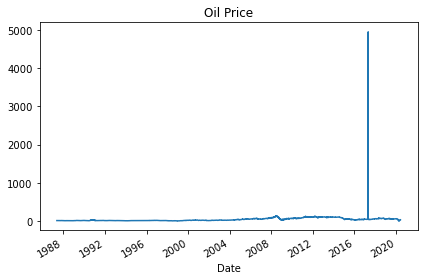

In [7]:
oil.Price.plot(title='Oil Price')
plt.tight_layout()
plt.savefig('./Plots/oil_prince.png', dpi=300)
plt.show()

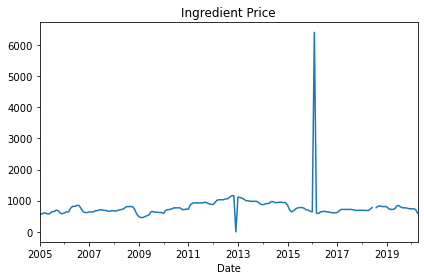

In [8]:
ingredient.Price.plot(title='Ingredient Price')
plt.tight_layout()
plt.savefig('./Plots/ingredient_price.png', dpi=300)
plt.show()

## Data Cleaning

### Oil

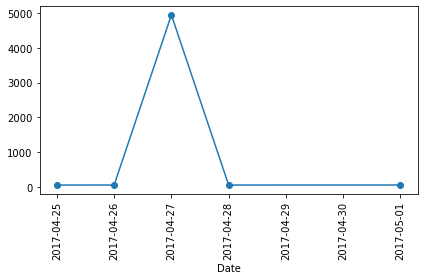

In [9]:
plt.plot(oil['2017-4-25':'2017-5-1'],marker='o')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('./Plots/oil_outlier.png', dpi=300)
plt.show()

In [10]:
oil['2017-4-25':'2017-5-1']

,Price
Date,
2017-04-25,49.37
2017-04-26,49.99
2017-04-27,4946.00
2017-04-28,49.46
2017-05-01,50.41


In [62]:
oil.loc['2017-4-27']['Price'] = 49.46

### Ingredients

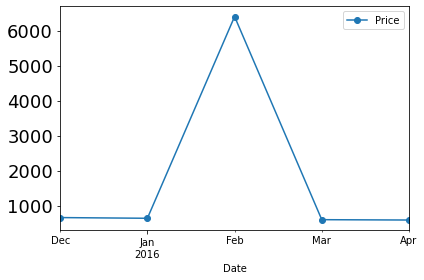

In [12]:
ingredient['2015-12':'2016-4'].plot(marker='o')
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('./Plots/ingredient_outlier1.png', dpi = 300, transparent=True)
plt.show()

In [13]:
ingredient['2015-12':'2016-4']

,Price
Date,
2015-12-01,660.0
2016-01-01,640.0
2016-02-01,6400.0
2016-03-01,600.0
2016-04-01,590.0


In [14]:
ingredient.loc['2016-2-1']['Price'] = 640.0

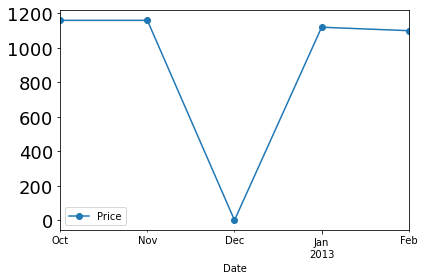

In [15]:
ingredient['2012-10':'2013-2'].plot(marker='o')
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('./Plots/ingredient_outlier2.png', dpi = 300, transparent=True)
plt.show()

In [16]:
ingredient['2012-10':'2013-2']

,Price
Date,
2012-10-01,1160.00
2012-11-01,1160.00
2012-12-01,1.13
2013-01-01,1120.00
2013-02-01,1100.00


In [17]:
ingredient.loc['2012-12-1']['Price'] = 1130.00

In [24]:
o_d = pd.DataFrame()
i_d = pd.DataFrame()
o_d['oil'] = oil.asfreq('D')
i_d['ingredient'] = ingredient.asfreq('D')
o_d = pd.concat([o_d, i_d], axis = 1)
o_d.dropna(axis=0, inplace=True)
o_d

,oil,ingredient
Date,,
2005-02-01,45.12,570.0
2005-03-01,50.47,610.0
2005-04-01,54.14,600.0
2005-06-01,50.46,590.0
2005-07-01,56.41,650.0
...,...,...
2019-07-01,65.10,840.0
2019-08-01,62.90,790.0
2019-10-01,60.06,770.0


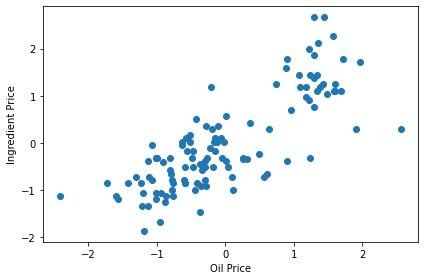

In [28]:
o_d.sort_values('oil', inplace=True)
plt.scatter((o_d['oil']-np.mean(o_d['oil']))/np.std(o_d['oil']), (o_d['ingredient']-np.mean(o_d['ingredient']))/np.std(o_d['ingredient']))
plt.xlabel('Oil Price')
plt.ylabel('Ingredient Price')
plt.tight_layout()
plt.show()

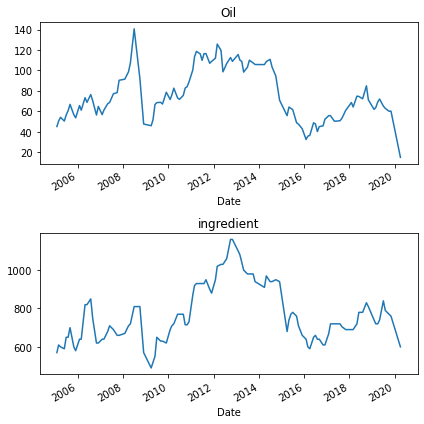

In [30]:
fig, axes = plt.subplots(2, figsize=(6,6))
o_d['oil'].plot(ax=axes[0], title='Oil')
o_d['ingredient'].plot(ax=axes[1], title='ingredient')
plt.tight_layout()

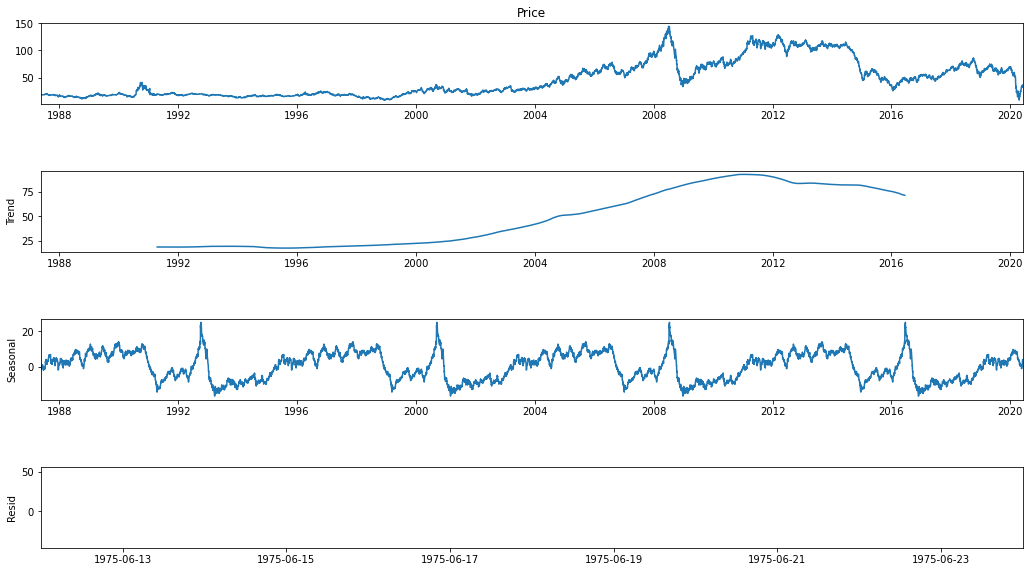

In [97]:
from statsmodels.tsa.seasonal import seasonal_decompose

# oilna = oil.loc['2005':'2005'].dropna().sort_index()
oilna = oil.dropna().sort_index()
analysis = oilna['Price'].copy()
decompose_result_mult = seasonal_decompose(analysis, model="additive", period=2000)
ternd = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid


fig = decompose_result_mult.plot()
fig.set_size_inches((16, 9))
plt.xlim(1988,2000)
plt.savefig('./Plots/seasonality.png', facecolor='white', dpi=300)
plt.show()

In [54]:
oil.dropna(inplace=True)

In [24]:
# Is data stationary?
# Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(oil)
print(f"pvalue = {pvalue}, if above 0.05 means data is not stationary")

pvalue = 0.21650600573267315, if above 0.05 means data is not stationary


Since data is not stationary, we may need SARIMA and not just ARIMA

In [28]:
oil['Year'] = [d.year for d in oil.index]
oil['Month'] = [d.strftime('%b') for d in oil.index]
oil.head()

,Price,Year,Month
Date,,,
1987-05-20,18.63,1987,May
1987-05-21,18.45,1987,May
1987-05-22,18.55,1987,May
1987-05-25,18.60,1987,May
1987-05-26,18.63,1987,May


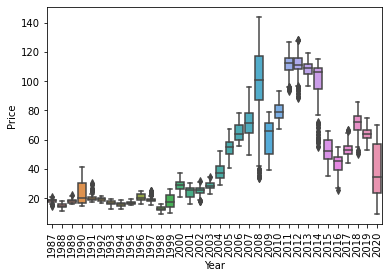

In [33]:
sns.boxplot(x='Year', y='Price', data = oil)
plt.xticks(rotation=90)
plt.show()

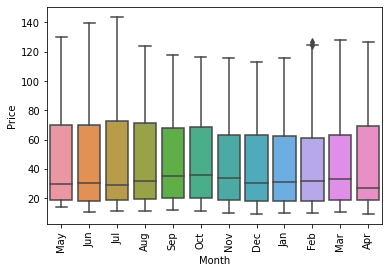

In [35]:
sns.boxplot(x='Month', y='Price', data = oil)
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

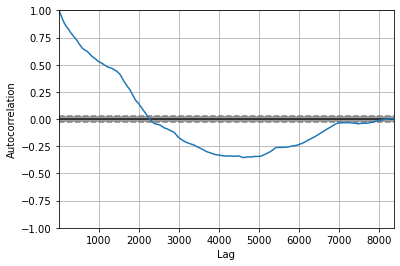

In [95]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(oil['Price'])